In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import sqrt
import pandas as pd
import scipy.constants as const
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit                        # Funktionsfit:     popt, pcov = curve_fit(func, xdata, ydata) 
from uncertainties import ufloat                            # Fehler:           fehlerwert =  ulfaot(x, err)
from uncertainties import unumpy as unp 
from uncertainties.unumpy import uarray                     # Array von Fehler: fehlerarray =  uarray(array, errarray)
from uncertainties.unumpy import (nominal_values as noms,   # Wert:             noms(fehlerwert) = x
                                  std_devs as stds)         # Abweichung:       stds(fehlerarray) = errarray

Tabelle erstellen:

In [26]:
dscan = pd.read_csv('tables/detektorscan.txt', delim_whitespace= "\t")
# print(dscan)
print(dscan.to_latex(index = False, column_format= "c c", decimal=',')) 

\begin{tabular}{c c}
\toprule
 theta &      I \\
\midrule
 -0,30 &   1836 \\
 -0,29 &   2122 \\
 -0,28 &   2236 \\
 -0,27 &   2418 \\
 -0,26 &   2579 \\
 -0,25 &   2644 \\
 -0,24 &   3160 \\
 -0,23 &   3646 \\
 -0,22 &   4368 \\
 -0,21 &   4898 \\
 -0,20 &   5479 \\
 -0,19 &   6142 \\
 -0,18 &   6781 \\
 -0,17 &   7939 \\
 -0,16 &   9296 \\
 -0,15 &  11164 \\
 -0,14 &  13036 \\
 -0,13 &  15916 \\
 -0,12 &  20495 \\
 -0,11 &  26592 \\
 -0,10 &  34614 \\
 -0,09 &  45569 \\
 -0,08 &  60869 \\
 -0,07 &  92128 \\
 -0,06 & 141444 \\
 -0,05 & 198646 \\
 -0,04 & 249182 \\
 -0,03 & 318370 \\
 -0,02 & 392259 \\
 -0,01 & 456486 \\
  0,00 & 506208 \\
  0,01 & 505924 \\
  0,02 & 445386 \\
  0,03 & 351661 \\
  0,04 & 252666 \\
  0,05 & 175980 \\
  0,06 & 124592 \\
  0,07 &  98877 \\
  0,08 &  69837 \\
  0,09 &  52169 \\
  0,10 &  36003 \\
  0,11 &  27611 \\
  0,12 &  22698 \\
  0,13 &  19287 \\
  0,14 &  17893 \\
  0,15 &  13613 \\
  0,16 &  11112 \\
  0,17 &   8819 \\
  0,18 &   6282 \\
  0,19 &   

Detektorscan:

a = 0.95784+/-0.00009
b = 0.0028+/-0.0006
mu = 0.001+/-0.014
I_max = 484867.2212693036
FWHM = 0.08792879287928795


(-0.32, 0.32)

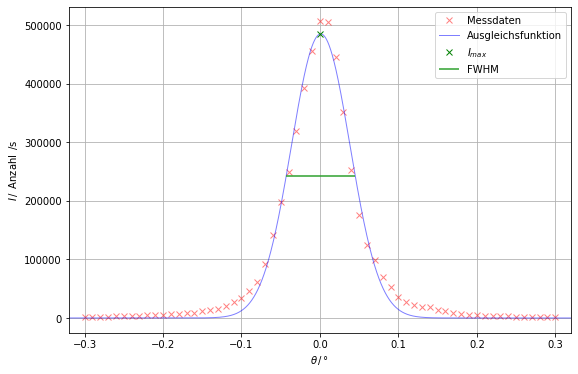

In [27]:
theta, I = np.genfromtxt('tables/detektorscan.txt', unpack=True, skip_header=1)
Imax = np.amax(I)
Inorm = I/Imax                              # Messdaten normieren

plt.figure(figsize=(9, 6))                  # Größe des Plots

plt.plot(theta, I, 'xr', markersize=6 , label = 'Messdaten', alpha=0.5)

n = len(theta)                              # Anzahl Daten
mean = sum(theta*Inorm)/n                   # note this correction
sigma0 = np.sqrt(sum(Inorm*(theta - mean)**2))

# Regression nach Gaußverteilung
def g(theta, a, b, mu):
    return a*np.exp(-(theta-mu)**2/(b))     # b = 2*sigma**2

para, pcov = curve_fit(g, theta, Inorm)#, p0=[sigma0,mean,1,1])
a, b, mu = para                             # a = Amplitude
pcov = np.sqrt(np.diag(pcov))
fmu, fa, fb = pcov
ua = ufloat(a, fa) 
ub = ufloat(b, fb)
umu = ufloat(mu, fmu)
print('a =', ua)
print('b =', ub)
print('mu =', umu)

xx = np.linspace(-0.4, 0.4, 10**4)
plt.plot(xx, g(xx, *para)*Imax, '-b', linewidth = 1, label = 'Ausgleichsfunktion', alpha=0.5)

gauss = g(xx, *para)*Imax
peak, _ = find_peaks(gauss)
peak = peak[0]
print('I_max =', gauss[peak])

a_halb = Imax * a/2

# Funktion zur Bestimmung der Halbwertspunkte
def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx, array[idx]

# Index und Wert des linken Halbwertspunkts
idx_l, l = find_nearest(gauss[:peak], a_halb)
# Index und Wert des rechten Halbwertspunkts
idx_r, r = find_nearest(gauss[peak:], a_halb)
idx_r += peak       # da index um peak verschoben

# Halbwertsbreite
fwhm = xx[idx_r] - xx[idx_l]
print('FWHM =', fwhm)

plt.plot(0, gauss[peak], "gx", label = '$I_{max}$')
# plt.axvline(gauss[idx_left], linestyle='--', color='red', label='Halbwertpunkt')
# plt.axvline(gauss[idx_right], linestyle='--', color='red')
plt.hlines(a_halb, xx[idx_l], xx[idx_r], color="C2", label='FWHM')

plt.xlabel(r'$\theta \, / \, \mathrm{°}$')
plt.ylabel(r'$I \, / \,$ Anzahl $\, / \mathrm{s}$')
plt.legend(loc="best")                  # legend position
plt.grid(True)                          # grid style
plt.xlim(-0.32, 0.32)
# plt.ylim(-0.05, 1.05)

Reflektivitätsscan und Diffuser Scan:

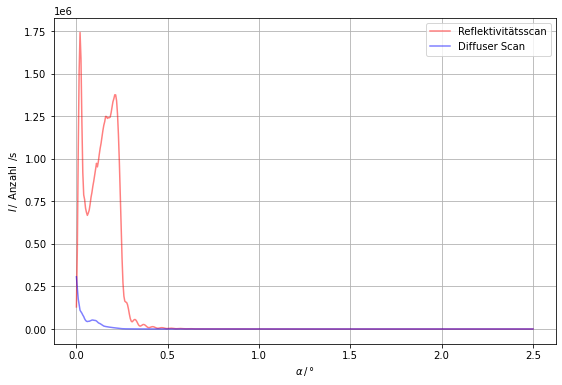

In [37]:
reflekt_scan = pd.read_csv('tables/reflektivitätsscan.txt', delim_whitespace= "\t")
diffuser_scan = pd.read_csv('tables/diffuser_scan.txt', delim_whitespace= "\t")
# print(reflekt_scan.to_latex(index = False, column_format= "c c", decimal=',')) 


alpha, I_ref = np.genfromtxt('tables/reflektivitätsscan.txt', unpack=True, skip_header=1)
alpha, I_diff = np.genfromtxt('tables/diffuser_scan.txt', unpack=True, skip_header=1)

plt.figure(figsize=(9, 6))                  # Größe des Plots

plt.plot(alpha, I_ref, '-r', markersize=6 , label = 'Reflektivitätsscan', alpha=0.5)
plt.plot(alpha, I_diff,'-b', markersize=6 , label = 'Diffuser Scan', alpha=0.5)

plt.xlabel(r'$\alpha \, / \, \mathrm{°}$')
plt.ylabel(r'$I \, / \,$ Anzahl $\, / \mathrm{s}$')
plt.legend(loc="best")
plt.grid(True)
plt.yscale('log')


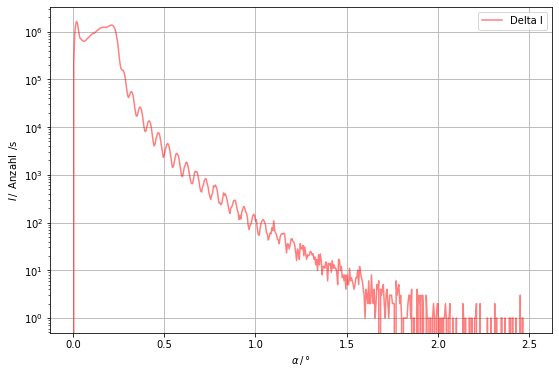

In [38]:
plt.figure(figsize=(9, 6))

delta_I = I_ref - I_diff
# print(I_ref)
# print(delta_I)
plt.plot(alpha, delta_I, '-r', markersize=6 , label = 'Delta I', alpha=0.5)
plt.xlabel(r'$\alpha \, / \, \mathrm{°}$')
plt.ylabel(r'$I \, / \,$ Anzahl $\, / \mathrm{s}$')
plt.legend(loc="best")
plt.grid(True)
plt.yscale('log')